In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
# for hyperparemeter optimisation
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, recall_score
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_predict

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


loading the data

In [3]:
# change the file names

meth = pd.read_csv('/content/drive/MyDrive/stuff for colab/liver/methy',delim_whitespace=True).transpose(copy = True)
mirna = pd.read_csv('/content/drive/MyDrive/stuff for colab/liver/mirna',delim_whitespace=True).transpose(copy = True)
exp = pd.read_csv('/content/drive/MyDrive/stuff for colab/liver/exp',delim_whitespace=True).transpose(copy = True)
surv = pd.read_csv('/content/drive/MyDrive/stuff for colab/liver/survival',delim_whitespace=True, index_col=0)
surv_compl = pd.read_csv('/content/drive/MyDrive/stuff for colab/liver/20150821-LIHC-Clinical', index_col=0, sep='\t').transpose(copy = True)


In [4]:
print(surv['Survival'].min(), surv['Survival'].max())
print(surv['Survival'].mean(), surv['Survival'].median())
print(len(surv[(surv['Survival'] <120) & (surv['Death'] == 0) ]))


1.0 3675.0
859.0833333333334 624.0
20


# New Section

In [4]:
surv.drop(surv[(surv['Survival'] <30) & (surv['Death'] == 0)].index, inplace=True)

In [6]:
len(surv[(surv['Survival'] <30) & (surv['Death'] == 0) ])

0

In [7]:
surv.shape

(423, 2)

In [5]:
# stage1 = surv_compl[surv_compl['pathologic_stage'] == 'stage i']
np.random.seed(0)

random_rows = surv_compl[surv_compl['pathologic_stage'] == 'stage i'].sample(n=30, random_state=0).index
random_rows1 = surv_compl[surv_compl['pathologic_stage'] == 'stage ii'].sample(n=10, random_state=0).index
aa = []
for i in surv.index:
  if i.lower()[:12] in random_rows or i.lower()[:12] in random_rows1:
    aa.append(i)

In [6]:
surv.drop(aa, inplace=True)
newIndex = surv.index.values
for i in range(len(newIndex)): newIndex[i]= newIndex[i].replace('-','.')
surv.set_index(newIndex)
surv.drop("Survival", axis = 1,inplace=True)
surv.dropna( inplace = True)
surv.head()

,Death
PatientID,
TCGA.2Y.A9GS.01,1.0
TCGA.2Y.A9GT.01,1.0
TCGA.2Y.A9GU.01,0.0
TCGA.2Y.A9GV.01,1.0
TCGA.2Y.A9GW.01,1.0


In [10]:
sum(surv['Death'])

160.0

In [7]:
print("meth info \n", meth.info())
print("exp info \n", exp.info())
print("mirna info \n", mirna.info())
print("surv info \n", surv.info())

<class 'pandas.core.frame.DataFrame'>
Index: 429 entries, TCGA.2V.A95S.01 to TCGA.ZS.A9CG.01
Columns: 5000 entries, cg00005740 to rs966367
dtypes: float64(5000)
memory usage: 16.4+ MB
meth info 
 None
<class 'pandas.core.frame.DataFrame'>
Index: 423 entries, TCGA.2V.A95S.01 to TCGA.ZS.A9CG.01
Columns: 20531 entries, X..100130426 to tAKR.389932
dtypes: float64(20531)
memory usage: 66.3+ MB
exp info 
 None
<class 'pandas.core.frame.DataFrame'>
Index: 424 entries, TCGA.2V.A95S.01 to TCGA.ZS.A9CG.01
Columns: 1046 entries, hsa.let.7a.1 to hsa.mir.99b
dtypes: float64(1046)
memory usage: 3.4+ MB
mirna info 
 None
<class 'pandas.core.frame.DataFrame'>
Index: 373 entries, TCGA.2Y.A9GS.01 to TCGA.ZS.A9CG.01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Death   373 non-null    float64
dtypes: float64(1)
memory usage: 5.8+ KB
surv info 
 None


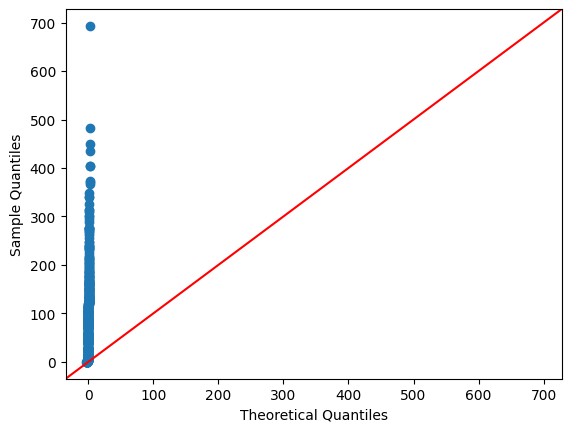

In [9]:
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(exp['tAKR.389932'], line='45')
plt.show()

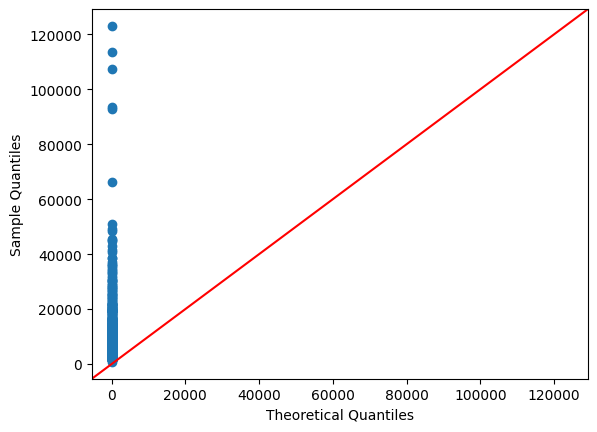

In [8]:
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(mirna['hsa.mir.99b'], line='45')
plt.show()

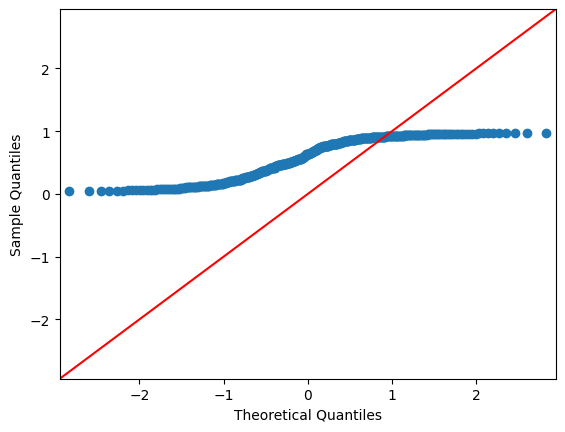

In [10]:
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(meth['cg00005740'], line='45')
plt.show()
#idk how to deal w random uniform dist

In [11]:
#you guys can copy-paste this part, i'm still testing if i need to scale the meth data further but this is what got me auc of 1 for svm
########################################################################################################################################
exp1 = np.log(exp+1)
scaler = StandardScaler().fit(exp1)
exp = pd.DataFrame(scaler.transform(exp1))
exp.columns = exp1.columns
exp.index = exp1.index


mirna1 = np.log(mirna+1) #this is wrong bc mirna contains a lot of elements between 0 and 1, idk if we can just add 1 altho it is just an offset
scaler = StandardScaler().fit(mirna1)
mirna = pd.DataFrame(scaler.transform(mirna1))
mirna.columns = mirna1.columns
mirna.index = mirna1.index

transformer = QuantileTransformer(output_distribution="normal").fit(meth)
meth1 = pd.DataFrame(transformer.transform(meth))
meth1.columns = meth.columns
meth1.index = meth.index
meth = meth1

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (429). n_quantiles is set to n_samples.
  warnings.warn(


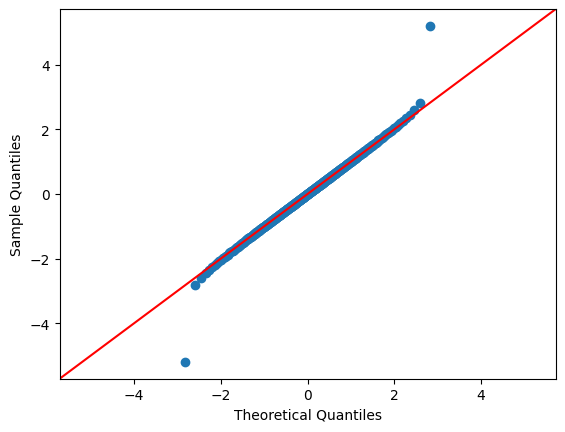

In [14]:
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(meth['cg00005740'], line='45')
plt.show()

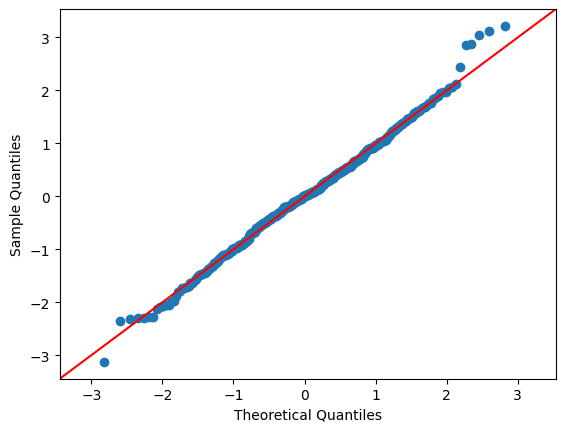

In [ ]:
fig = sm.qqplot(mirna['hsa.mir.99b'], line='45')
plt.show()

In [12]:
LG = meth.merge(exp, left_index = True, right_index=True, how='inner')
LG = LG.merge(mirna, left_index = True, right_index=True, how='inner')
LG = LG.merge(surv, left_index = True, right_index=True, how='inner')

In [13]:
print(meth.shape)
print(exp.shape)
print(mirna.shape)
print(surv.shape)

(429, 5000)
(423, 20531)
(424, 1046)
(373, 1)


In [16]:
sum(LG['Death'])

144.0

In [ ]:
len(LG.columns)

26578

over n under sampling

In [14]:
# scaler = StandardScaler()

over = SMOTE(sampling_strategy=0.9, random_state = 0)
rus = RandomUnderSampler(sampling_strategy = 0.8, random_state=0, replacement=True)

# check if the feature labels are retained after this one// they are

In [15]:
meth = LG[LG.columns[0:5000]]
exp = LG[LG.columns[5000:len(LG.columns)-1047]]
mirna = LG[LG.columns[len(LG.columns)-1047:len(LG.columns)-1]]
y=LG[LG.columns[-1]]

In [16]:
print("meth info \n", meth.info())
print("exp info \n", exp.info())
print("mirna info \n", mirna.info())
print(y)

<class 'pandas.core.frame.DataFrame'>
Index: 347 entries, TCGA.2Y.A9GS.01 to TCGA.ZS.A9CG.01
Columns: 5000 entries, cg00005740 to rs966367
dtypes: float64(5000)
memory usage: 13.2+ MB
meth info 
 None
<class 'pandas.core.frame.DataFrame'>
Index: 347 entries, TCGA.2Y.A9GS.01 to TCGA.ZS.A9CG.01
Columns: 20531 entries, X..100130426 to tAKR.389932
dtypes: float64(20531)
memory usage: 54.4+ MB
exp info 
 None
<class 'pandas.core.frame.DataFrame'>
Index: 347 entries, TCGA.2Y.A9GS.01 to TCGA.ZS.A9CG.01
Columns: 1046 entries, hsa.let.7a.1 to hsa.mir.99b
dtypes: float64(1046)
memory usage: 2.8+ MB
mirna info 
 None
TCGA.2Y.A9GS.01    1.0
TCGA.2Y.A9GT.01    1.0
TCGA.2Y.A9GU.01    0.0
TCGA.2Y.A9GV.01    1.0
TCGA.2Y.A9GW.01    1.0
                  ... 
TCGA.ZS.A9CD.01    1.0
TCGA.ZS.A9CE.01    0.0
TCGA.ZS.A9CF.01    0.0
TCGA.ZS.A9CF.02    0.0
TCGA.ZS.A9CG.01    0.0
Name: Death, Length: 347, dtype: float64


Feature Selection

In [ ]:
# change this to be the C (has to be [0,1])
Cvals = [0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

# meth using default/mean is 1994
# exp using default/mean is 222
# mirna using default/mean is 4410
# optimal hyperparam for GB obtained from differential analysis classifiers
gb_est = GradientBoostingClassifier(n_estimators=1500, max_features=8, random_state=14)
aucB=0

# Select From model takes the features that scored  or some proportion thing (median or sth)
#i can set max_features but wht does it do really if it ends up being less

# what I can do is actually set the C in logreg to be larger, the smaller it is the less features we get (idk it might be the error allowance like in the lecture)
for i in Cvals:
  # check this part again
  sel3 = SelectFromModel(LogisticRegression(C=i,
                    random_state=0,
                    penalty = 'l1',
                    solver = 'liblinear'))
  sel3.fit(exp,y)
  cols_ids = sel3.get_support(indices=True)
  LGexp = exp.iloc[:,cols_ids].copy()

  for j in Cvals:
    sel2 = SelectFromModel(LogisticRegression(C =j,
                         random_state=0,
                         penalty = 'l1',
                         solver = 'liblinear'))
    sel2.fit(meth, y)
    cols_ids = sel2.get_support(indices=True) #indices is true here, it should be fine
    LGmeth = meth.iloc[:,cols_ids].copy()

    LGf = pd.concat([LGexp, LGmeth], axis = 1)

    for k in Cvals:
      sel1 = SelectFromModel(LogisticRegression(C =k,
                    random_state=0,
                    penalty = 'l1',
                    solver = 'liblinear'))
      sel1.fit(mirna,y)
      cols_ids = sel1.get_support(indices=True)
      LGmirna = mirna.iloc[:,cols_ids].copy()


      LG = pd.concat([LGf, LGmirna], axis = 1)

      # print(LG.head())

      X_train,X_test,Y_train,Y_test=train_test_split(LG, y,
                                                     test_size=0.33,
                                                     train_size =  0.67,
                                                     stratify=y,
                                                     random_state=0)

      X, Y = rus.fit_resample(X_train, Y_train)
      X,Y_train= over.fit_resample(X, Y)
      X_train = pd.DataFrame(X)

      # Fit the classifier on the training data
      gb_est.fit(X_train, Y_train)

      # Predict probabilities on the test data
      probs = gb_est.predict_proba(X_test)

      # Extract the probabilities of the positive class
      positive_class_probs = probs[:, 1]

      # Calculate the AUC score
      auc= roc_auc_score(Y_test, positive_class_probs)
      if auc > aucB:
        print('best input so far (i,j,k)', i, " ",j," ",k)
        print('\n AUC score:', auc)
        print('---------------------------------------------------------')
        aucB = auc

Classifiers

In [27]:
# now Cmirna = 0.1, Cmeth = 0.1, Cexp = 0.4
sel1 = SelectFromModel(LogisticRegression(C =0.1,
                    random_state=0,
                    penalty = 'l1',
                    solver = 'liblinear'))
sel1.fit(mirna,y)
cols_ids = sel1.get_support(indices=True)
LGmirna = mirna.iloc[:,cols_ids].copy()


sel2 = SelectFromModel(LogisticRegression(C =0.1,
                    random_state=0,
                    penalty = 'l1',
                    solver = 'liblinear'))
sel2.fit(meth, y)
cols_ids = sel2.get_support(indices=True) #indices is true here, it should be fine
LGmeth = meth.iloc[:,cols_ids].copy()

sel3 = SelectFromModel(LogisticRegression(C=0.4,
                    random_state=0,
                    penalty = 'l1',
                    solver = 'liblinear'))
sel3.fit(exp,y)
cols_ids = sel3.get_support(indices=True)
LGexp = exp.iloc[:,cols_ids].copy()

LG = pd.concat([LGexp, LGmeth, LGmirna], axis = 1)

print(LG.info())

X_train,X_test,Y_train,Y_test=train_test_split(LG, y,
                                                test_size=0.33,
                                                train_size =  0.67,
                                                stratify=y,
                                                random_state=0)

<class 'pandas.core.frame.DataFrame'>
Index: 347 entries, TCGA.2Y.A9GS.01 to TCGA.ZS.A9CG.01
Columns: 374 entries, X..100133144 to hsa.mir.9.2
dtypes: float64(374)
memory usage: 1.0+ MB
None


In [28]:
X, Y = rus.fit_resample(X_train, Y_train)
X,Y_train= over.fit_resample(X, Y)
X_train = pd.DataFrame(X)

In [29]:
gb_est = GradientBoostingClassifier(n_estimators=1500, max_features=8, random_state=14)
kfold = KFold(n_splits=10, shuffle=True, random_state=0)


In [30]:
# GB CLASSIFIER
# Fit the classifier on the training data
probabilities_train = cross_val_predict(gb_est, X_train, Y_train, cv=kfold, method='predict_proba')
Y_pred_train = [0 if p[0] > 0.5 else 1 for p in probabilities_train]

# Calculate scores
accuracy = accuracy_score(Y_train, Y_pred_train)
precision = precision_score(Y_train, Y_pred_train)
recall = recall_score(Y_train, Y_pred_train)
recall2 = recall_score(Y_train, Y_pred_train, pos_label = 0)
f1 = f1_score(Y_train, Y_pred_train)

# Print the scores
print("For training data:")
print("Accuracy : %.3f" % accuracy)
print("Precision : %.3f" % precision)
print("Recall : %.3f" % recall)
print("F1-score : %.3f" % f1)
recall2

For training data:
Accuracy : 0.930
Precision : 0.951
Recall : 0.898
F1-score : 0.924


0.9583333333333334

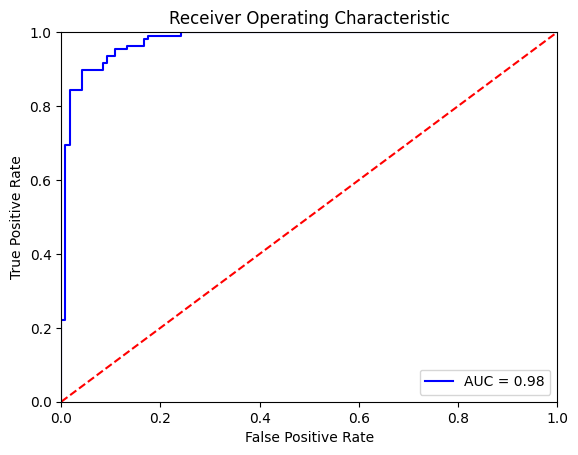

In [31]:
fpr, tpr, threshold = metrics.roc_curve(Y_train, probabilities_train[:,1])
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [32]:
# Fit the classifier on the training data
gb_est.fit(X_train, Y_train)

# Predict probabilities on the test data
probs = gb_est.predict_proba(X_test)

In [33]:
probstn = gb_est.predict_proba(X_train)

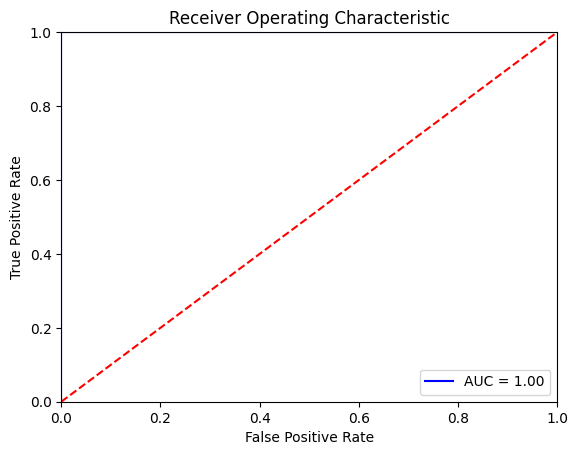

For training data:
Accuracy : 1.000
Precision : 1.000
Recall : 1.000
F1-score : 1.000
ROC: 1.000


1.0

In [34]:
Y_pred_train = [0 if p[0] > 0.5 else 1 for p in probstn]


fpr, tpr, threshold = metrics.roc_curve(Y_train, probstn[:,1])
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Calculate scores
accuracy = accuracy_score(Y_train, Y_pred_train)
precision = precision_score(Y_train, Y_pred_train)
recall = recall_score(Y_train, Y_pred_train)
recall2 = recall_score(Y_train, Y_pred_train, pos_label=0)
f1 = f1_score(Y_train, Y_pred_train)
positive_class_probs = probstn[:, 1]
auc= roc_auc_score(Y_train, positive_class_probs)

# Print the scores
print("For training data:")
print("Accuracy : %.3f" % accuracy)
print("Precision : %.3f" % precision)
print("Recall : %.3f" % recall)
print("F1-score : %.3f" % f1)
print("ROC: %.3f" % auc)
recall2

In [35]:
Y_pred_test = [0 if p[0] > 0.5 else 1 for p in probs]


# Calculate scores
accuracy = accuracy_score(Y_test, Y_pred_test)
precision = precision_score(Y_test, Y_pred_test)
recall = recall_score(Y_test, Y_pred_test)
recall2 = recall_score(Y_train, Y_pred_train, pos_label = 0)
f1 = f1_score(Y_test, Y_pred_test)
positive_class_probs = probs[:, 1]
auc= roc_auc_score(Y_test, positive_class_probs)

# Print the scores
print("For testing data:")
print("Accuracy : %.3f" % accuracy)
print("Precision : %.3f" % precision)
print("Recall : %.3f" % recall)
print("F1-score : %.3f" % f1)
print("ROC: %.3f" % auc)
recall2

For testing data:
Accuracy : 0.826
Precision : 0.780
Recall : 0.812
F1-score : 0.796
ROC: 0.891


1.0

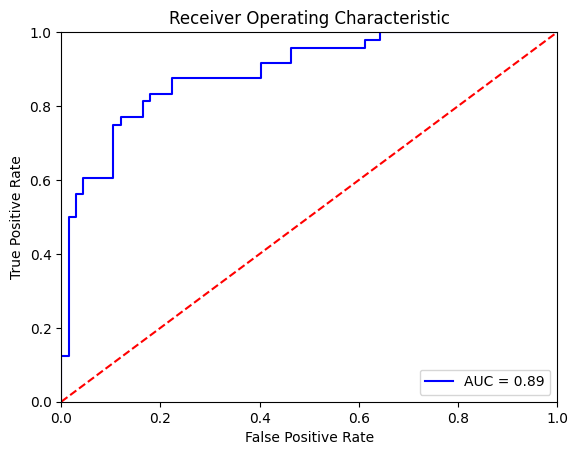

In [36]:
fpr, tpr, threshold = metrics.roc_curve(Y_test, probs[:,1])
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5, 1.0, 'Gradient Boost feature importance')

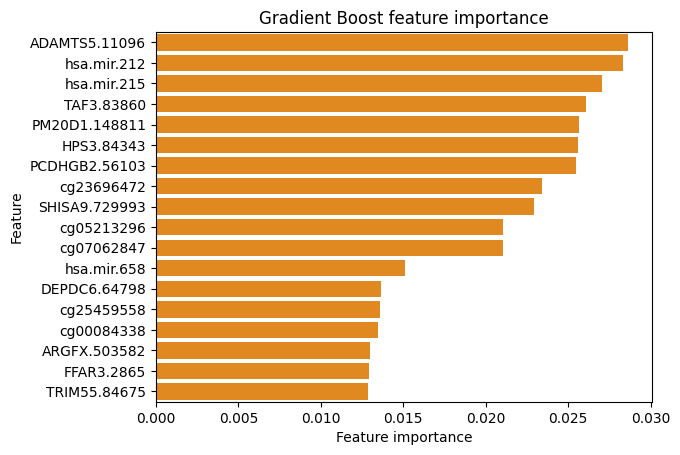

In [37]:
feature_import = pd.DataFrame([LG.columns,gb_est.feature_importances_]).T
feature_import.columns = ['feature', 'importance']
aa = feature_import.copy()
feature_import.sort_values('importance', ascending=False, inplace=True)
sns.barplot(y='feature', x='importance', data=feature_import.head(18), color='darkorange')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.title('Gradient Boost feature importance')
# feature_import
# feature_import.head(18)

In [32]:
# SVM CLASSIFIER
from sklearn.svm import SVC
aucB = 0
Cvals = [0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

for i in Cvals:
  clf = SVC(kernel='linear', C=i,probability=True).fit(X_train, Y_train)
  probs = clf.predict_proba(X_test)
  positive_class_probs = probs[:, 1]

  # Calculate the AUC score
  auc= roc_auc_score(Y_test, positive_class_probs)
  if auc > aucB:
    print('best input so far ', i)
    print('\n AUC score:', auc)
    print('---------------------------------------------------------')
    aucB = auc

best input so far  0.1

 AUC score: 0.9996890547263682
---------------------------------------------------------


In [33]:
probabilities_train = cross_val_predict(SVC(kernel='linear', C=0.1,probability=True), X_train, Y_train, cv=kfold, method='predict_proba')
Y_pred_train = [0 if p[0] > 0.5 else 1 for p in probabilities_train]


# Calculate scores
accuracy = accuracy_score(Y_train, Y_pred_train)
precision = precision_score(Y_train, Y_pred_train)
recall = recall_score(Y_train, Y_pred_train)
f1 = f1_score(Y_train, Y_pred_train)

# Print the scores
print("For training data:")
print("Accuracy : %.3f" % accuracy)
print("Precision : %.3f" % precision)
print("Recall : %.3f" % recall)
print("F1-score : %.3f" % f1)

For training data:
Accuracy : 0.982
Precision : 0.981
Recall : 0.981
F1-score : 0.981


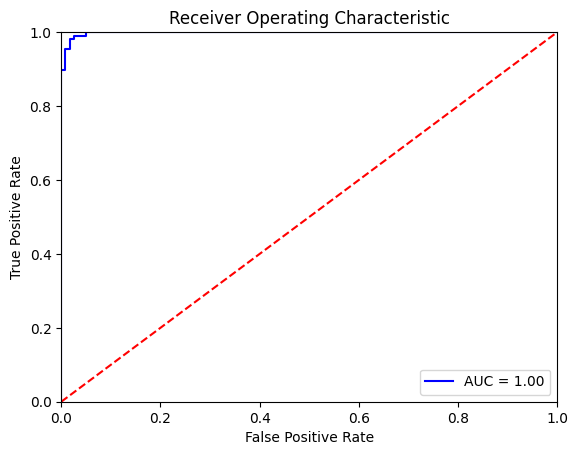

In [34]:
fpr, tpr, threshold = metrics.roc_curve(Y_train, probabilities_train[:,1])
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [35]:
clf = SVC(kernel='linear', C=0.1,probability=True).fit(X_train, Y_train)

# Predict probabilities on the test data
probs = clf.predict_proba(X_test)

Y_pred_test = [0 if p[0] > 0.5 else 1 for p in probs]


# Calculate scores
accuracy = accuracy_score(Y_test, Y_pred_test)
precision = precision_score(Y_test, Y_pred_test)
recall = recall_score(Y_test, Y_pred_test)
recall2 = recall_score(Y_test, Y_pred_test, pos_label=0)
f1 = f1_score(Y_test, Y_pred_test)
positive_class_probs = probs[:, 1]
auc= roc_auc_score(Y_test, positive_class_probs)

# Print the scores
print("For testing data:")
print("Accuracy : %.3f" % accuracy)
print("Precision : %.3f" % precision)
print("Recall : %.3f" % recall)
print("F1-score : %.3f" % f1)
print("ROC: %.3f" % auc)
recall2

For testing data:
Accuracy : 0.991
Precision : 1.000
Recall : 0.979
F1-score : 0.989
ROC: 1.000


1.0

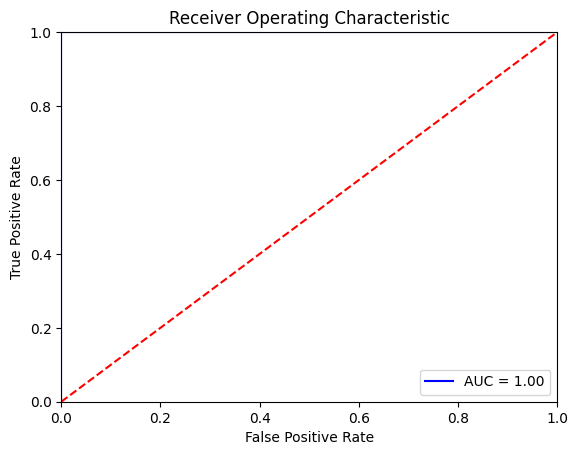

For training data:
Accuracy : 1.000
Precision : 1.000
Recall : 1.000
F1-score : 1.000
ROC: 1.000


1.0

In [36]:
probstn = clf.predict_proba(X_train)

Y_pred_train = [0 if p[0] > 0.5 else 1 for p in probstn]


fpr, tpr, threshold = metrics.roc_curve(Y_train, probstn[:,1])
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Calculate scores
accuracy = accuracy_score(Y_train, Y_pred_train)
precision = precision_score(Y_train, Y_pred_train)
recall = recall_score(Y_train, Y_pred_train)
recall2 = recall_score(Y_train, Y_pred_train, pos_label=0)
f1 = f1_score(Y_train, Y_pred_train)
positive_class_probs = probstn[:, 1]
auc= roc_auc_score(Y_train, positive_class_probs)

# Print the scores
print("For training data:")
print("Accuracy : %.3f" % accuracy)
print("Precision : %.3f" % precision)
print("Recall : %.3f" % recall)
print("F1-score : %.3f" % f1)
print("ROC: %.3f" % auc)
recall2

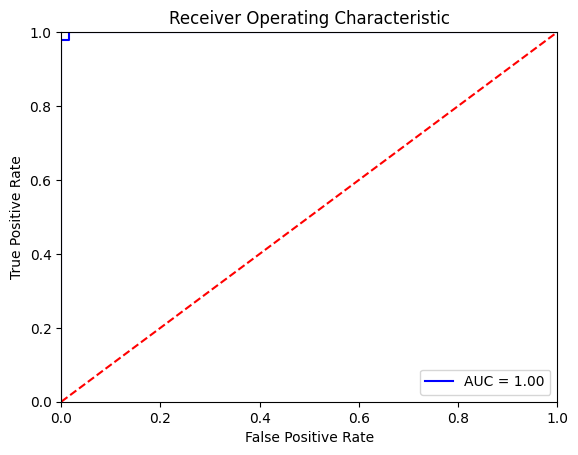

In [37]:
fpr, tpr, threshold = metrics.roc_curve(Y_test, probs[:,1])
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5, 1.0, 'SVM feature importance')

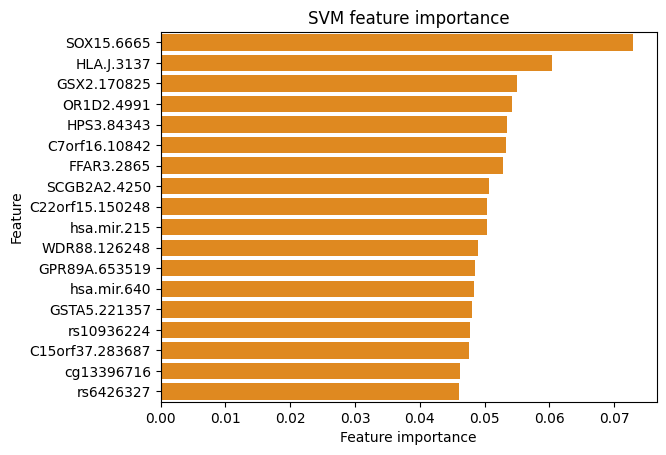

In [38]:
feature_import = pd.DataFrame([LG.columns,abs(clf.coef_)[0]]).T
feature_import.columns = ['feature', 'importance']
aa2 = feature_import.copy()
feature_import.sort_values('importance', ascending=False, inplace=True)
sns.barplot(y='feature', x='importance', data=feature_import.head(18), color='darkorange')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.title('SVM feature importance')
# feature_import
# feature_import.head(18)

In [ ]:
aa.to_csv('imp_features_gb_logreg.csv', index=False)

In [ ]:
aa2.to_csv('imp_features_svm_logreg.csv', index=False)

In [ ]:
len(LGmirna.columns)

82

In [ ]:
len(LGexp.columns)

219

In [ ]:
len(LGmeth.columns)

73

In [ ]:
mirna = aa.iloc[0:219].copy()
meth = aa.iloc[219:292].copy()
exp = aa.iloc[292:].copy()

In [ ]:
mirna = aa2.iloc[0:219].copy()
meth = aa2.iloc[219:292].copy()
exp = aa2.iloc[292:].copy()

In [ ]:
mirna.sort_values('importance', ascending=False, inplace=True)
meth.sort_values('importance', ascending=False, inplace=True)
exp.sort_values('importance', ascending=False, inplace=True)


In [ ]:
mirna.head()

,feature,importance
0,X..100133144,0.009777
1,ABP1.26,0.007423
2,ACOXL.55289,0.021113
3,ACSM4.341392,0.040499
4,ADAMTS5.11096,0.030658


In [ ]:
meth.head()


,feature,importance
219,cg00084338,0.009414
220,cg00114913,0.003468
221,cg00187686,0.016258
222,cg00674365,0.015707
223,cg00958884,0.023815


In [ ]:
exp.head()

,feature,importance
292,hsa.mir.106a,0.012572
293,hsa.mir.1185.1,0.018532
294,hsa.mir.1238,0.018126
295,hsa.mir.126,0.004778
296,hsa.mir.1260,0.01573
